In [1]:
import scipy
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import eval_hermite
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
import sys

Text(0, 0.5, '$x_1, x_2$')

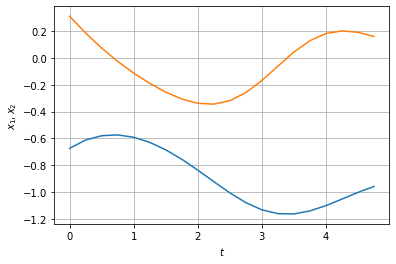

In [2]:
# このセルは、サンプルの時系列を保存したい場合には、データ番号や乱数のシードなどを変更する必要あり

# 学習用データの作成
Dt_obs = 0.25      # データ出力の際の時間刻み。odeintを使う場合、もっと細かい刻みでシミュレーションをして、指定したところだけ出力してくれる様子。
T = 5.0            # シミュレーションの最終時刻。
num_train_samples = 10   # サンプル数。時刻 T までの時系列データを num_samples 個作成する。
time_array = np.arange(0,T,Dt_obs) # 出力時間のための配列

# パラメータ
dim = 2
alpha = 1.0
beta = -1.0
delta = 0.5

def duffing(x,t,alpha,beta,delta) :
  return [x[1], -delta*x[1]-x[0]*(beta+alpha*x[0]**2)]

# シミュレーション
np.random.seed(3633914) # 乱数のシードを固定。
X = np.zeros((0,dim)) # EDMD用のデータ行列（時間発展前のもの）
Y = np.zeros((0,dim)) # EDMD用のデータ行列（時間発展後のもの）
train_data = [] # EDMD用途は別に、サンプルごとの時系列データを格納しておく。誤差の計算に利用。
for s in range(num_train_samples):
    # random_sample(2)で２次元の乱数生成。ただし [0,-1)の範囲なので、[-2,2) へと変換
    x0 = (np.random.random_sample(2)-0.5) * 2.0
    result = odeint(duffing, x0, time_array, args=(alpha,beta,delta))
    X = np.concatenate([X, result[:-1]], 0) # EDMD用のデータ配列。サンプルごとではなく、まとめてしまう
    Y = np.concatenate([Y, result[1:]], 0)  # 同上。ただし、ひとつ先の時刻のものを格納。
    train_data.append(result.T)   # サンプルごとに時系列データを格納。転置のほうがプロットしやすい。

# Pythonの配列ではなく、numpy形式に変換しておく
train_data = np.array(train_data)

# データのプロット（サンプル番号を一つ指定）
sample_number = 3
plt.grid()
plt.plot(time_array, train_data[sample_number][0])
plt.plot(time_array, train_data[sample_number][1])
plt.xlabel(r'$t$')
plt.ylabel(r'$x_1, x_2$')

In [3]:
# このセルはいじる必要なし

# 2変数での辞書を考える際に必要なパターンを作成する。
# 例えば 2nd order まで考える場合には
# H_2(x_1)*H_0(x_2), H_1(x_1)*H_1(x_2), H_0(x_1)*H_2(x_2)
# を考える必要がある。このとき [2,0] [1,1] [0,2] といった配列を作る必要がある。
# 二次元と決まっていれば簡単だが、高次元に対しても適用可能な方法。
def next_monomial_powers(c, dim):
    '''
    Make a next list for multivariate monomials.

    This implementation is based on John Burkardt's MONOMIAL toolbox.
    https://people.sc.fsu.edu/~jburkardt/py_src/monomial/monomial.html
    '''
    j = 0
    for i in range(1, dim):
        if 0 < c[i]:
            j = i
            break
    if j == 0:
        t = c[0]
        c[0] = 0
        c[dim-1] = t + 1
    elif j < (dim-1):
        c[j] = c[j] - 1
        t = c[0] + 1
        c[0] = 0
        c[j-1] = c[j-1] + t
    elif j == (dim-1):
        t = c[0]
        c[0] = 0
        c[j-1] = t + 1
        c[j] = c[j] - 1
    return c

def make_monomial_powers(d, p):
    '''
    Calculate all indices for monomials in d dimensions up to p-th order.
    '''
    n = comb(d+p, p, exact=True) # number of monomials
    x = np.zeros(d, dtype=int) # vector containing powers for the monomials, initially zero
    c = []
    c.append(x.copy())
    for i in range(1, n):
        x = next_monomial_powers(x,d)
        c.append(np.flip(x.copy()))
    return np.array(c)

class hermite(object):
    '''
    Compute Hermite dictionaries in d dimensions.
    '''
    def __init__(self, p):
        '''
        The parameter p defines the maximum order of the Hermite function.
        '''
        self.order = p

    def __call__(self, x):
        '''
        Evaluate dictionaries up to order p for a data point.
        '''
        d = x.shape[0]
        list_exponent = make_monomial_powers(d, self.order)
        result_powers = eval_hermite(list_exponent, x)
        vec_psi = np.prod(result_powers, axis=1)
        return vec_psi[:,np.newaxis]

class monomials(object):
    '''
    Compute monomials in d dimensions.
    '''
    def __init__(self, p):
        '''
        The parameter p defines the maximum order of the monomials.
        '''
        self.order = p

    def __call__(self, x):
        '''
        Evaluate all monomials up to order p for a data point.
        '''
        d = x.shape[0]
        list_exponent = make_monomial_powers(d, self.order)
        result_powers = np.power(x, list_exponent)
        vec_psi = np.prod(result_powers, axis=1)
        return vec_psi[:,np.newaxis]

In [4]:
# このセルは、クラスタ数を変更して実験する際などに修正する必要あり

# RBF 辞書のための準備
# Koopman行列を作るときと、あとで検証するときとで同じクラスタを使う必要がある。
# kmeansは初期値を変更してしまうので、ここではまずクラスタを作ってから、その変数を使うことにする。
num_clusters_rbf = 20   # クラスタ数の指定
kmeans = KMeans(n_clusters=num_clusters_rbf)
kmeans.fit(X)
rbf_centers = kmeans.cluster_centers_  # クラスタリングの結果得られた中心座標を保存

In [5]:
# このセルはいじる必要なし
# ただし、辞書の作り方に注意。RBFの部分だけではなく、定数と full state observableのための拡張をしている。
# 二次元の場合には
# [1, x_1, x_2, rbf_1, rbf_2, ...]
# のようになる。

# RBF辞書
class rbf(object):
    def __init__(self, n_clusters, rbf_centers):
        self.n_clusters = n_clusters
        self.rbf_centers = rbf_centers

    def __call__(self, x):
        '''
        Evaluate all monomials up to order p for a data point.
        '''
        vec_psi = np.ones(1) # [1] を作る
        vec_psi = np.concatenate([vec_psi,x],0) # 辞書に座標そのものを追加
        # RBFの追加
        x = x[np.newaxis,:]
        eudist = euclidean_distances(self.rbf_centers, x)
        eudist = eudist.flatten()
        TPS = np.power(eudist, 2)*np.log(eudist+10e-4)
        vec_psi = np.concatenate([vec_psi, TPS],0)
        return vec_psi[:,np.newaxis]

In [6]:
# このセルもいじる必要なし。EDMDの定義（ただしWilliams論文とは少し違う）

# Define the main routine for EDMD
def edmd(X, Y, psi):
    '''
    EDMD algorithm. The inputs are the matricies X and Y for the snapshot pairs.
    
    :param psi:      Basis functions, which will be given as a class object.
    :return:         Koopman matrix K.
    '''
    # Check the size of dictionaries
    m = psi(X[0]).shape[0]
    A = np.zeros([m,m])
    G = np.zeros([m,m])
    for x, y in zip(X, Y):
        psi_x = psi(x)
        psi_y = psi(y)
        A = A + psi_y @ psi_x.T
        G = G + psi_x @ psi_x.T
    K = A @ scipy.linalg.pinv(G)
    return K

In [7]:
# このセルが、それぞれの手法で Koopman 行列を作成する部分
# べき乗とHermite辞書を使った場合のパラメータ（最大次数）の指定も必要
# なお、上のほうでRBFのクラスタ数を変更したら、このセルの再実行が必要

# べき乗の単項式とHermite辞書の場合の最大次数
max_order_of_monomials = 3

# べき乗の単項式での Koopman行列
K_mono = edmd(X, Y, psi=monomials(max_order_of_monomials))

# 各次元についてHermiteで考えて、その積で辞書を構成した場合の Koopman 行列
K_herm = edmd(X, Y, psi=hermite(max_order_of_monomials))

# RBFを用いた辞書の場合の Koopman 行列
K_rbf = edmd(X, Y, psi=rbf(num_clusters_rbf, rbf_centers))

[[ 1.12092487  0.46661488]
 [-1.22822944  0.05549731]
 [ 0.81728079 -0.29733925]
 [-0.29863159 -0.25517638]
 [-0.16091083  0.77483168]
 [-0.72267809  0.03864587]
 [ 1.26982935  0.1087109 ]
 [-0.70865115 -0.34750191]
 [ 0.42225926  0.62274067]
 [ 0.74033139  0.24383998]
 [ 1.00903271  0.01048312]
 [-0.87518339 -0.8365274 ]
 [-0.23319731  0.10743413]
 [ 0.16158525 -0.42864297]
 [-0.5999446   0.63803063]
 [-1.03542756  0.35285248]
 [ 1.15965457 -0.33673506]
 [ 0.60938469 -0.03334659]
 [-1.05957714 -0.31458564]
 [ 0.85948384  0.6962174 ]]
[[-0.98288963 -0.52019678]]
[ 4.55537569 -0.18293954  1.96112912 -0.16593429  1.00802001 -0.18322476
  4.65022665 -0.11801962  1.95069383  2.25439291  3.07600003 -0.12206566
 -0.02055103  0.18323842  0.29700566 -0.10159882  3.54261804  1.41515143
 -0.07281801  3.86221241]
[[ 1.12092487  0.46661488]
 [-1.22822944  0.05549731]
 [ 0.81728079 -0.29733925]
 [-0.29863159 -0.25517638]
 [-0.16091083  0.77483168]
 [-0.72267809  0.03864587]
 [ 1.26982935  0.1087109

In [8]:
# このセルは、検証のためのデータ作成用。サンプル数を変える際などに変更が必要。

# 乱数の種の変更。種を変えていくつかデータを眺めてみると、良い事例、悪い事例を探せるはず。
np.random.seed(783914) 

# 検証用のサンプル数
num_test_samples = 10

# シミュレーション
time_array = np.arange(0,2*T,Dt_obs) # 出力時間のための配列
test_data = [] # サンプルごとの時系列データを格納
for s in range(num_test_samples):
    # random_sample(2)で２次元の乱数生成。ただし [0,-1)の範囲なので、[-2,2) へと変換
    x0 = (np.random.random_sample(2)-0.5) * 2.0
    result = odeint(duffing, x0, time_array, args=(alpha,beta,delta))
    test_data.append(result.T)   # サンプルごとに時系列データを格納。転置のほうがプロットしやすい。

# Pythonの配列ではなく、numpy形式に変換しておく
test_data = np.array(test_data)


Text(0, 0.5, '$x_1, x_2$')

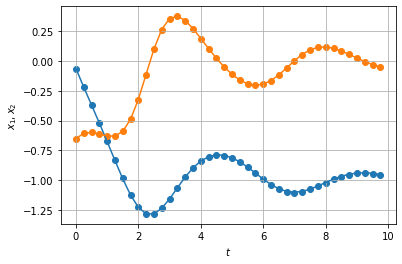

In [9]:
# べき乗辞書の確認用
mono_data = []
psi = monomials(max_order_of_monomials)
K = K_mono

for test_sample in test_data:
    x = test_sample.T[0]
    xs = np.zeros((0,dim))
    xs = np.concatenate([xs,x[np.newaxis,:]],0).T
    for step in range(test_data.shape[2]-1):
        psi_x = psi(x)
        next_dic =  K @ psi_x
        # べき乗の辞書の場合には、（0から数えて）1 と 2 の要素がそれぞれ x_1 と x_2 に対応。
        x = np.array([next_dic[1,0], next_dic[2,0]])
        x_T = x[np.newaxis,:].T
        xs = np.concatenate([xs,x_T],1)
    mono_data.append(xs)

mono_data = np.array(mono_data)

# データのプロット（サンプル番号を一つ指定）
sample_number = 2
plt.grid()
plt.plot(time_array, test_data[sample_number][0])
plt.plot(time_array, test_data[sample_number][1])
plt.scatter(time_array, mono_data[sample_number][0])
plt.scatter(time_array, mono_data[sample_number][1])
plt.xlabel(r'$t$')
plt.ylabel(r'$x_1, x_2$')

Text(0, 0.5, '$x_1, x_2$')

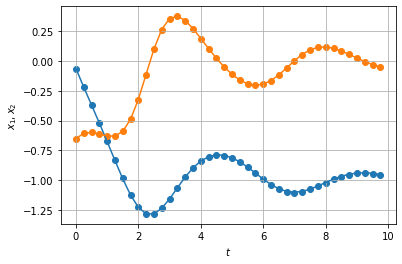

In [10]:
# Hermite辞書の確認用
hermite_data = []
psi = hermite(max_order_of_monomials)
K = K_herm

for test_sample in test_data:
    x = test_sample.T[0]
    xs = np.zeros((0,dim))
    xs = np.concatenate([xs,x[np.newaxis,:]],0).T
    for step in range(test_data.shape[2]-1):
        psi_x = psi(x)
        next_dic =  K @ psi_x
        # hermite辞書の場合には、（0から数えて）1 と 2 の要素に 0.5倍したものが、それぞれ x_1 と x_2 に対応。
        x = np.array([next_dic[1,0]*0.5, next_dic[2,0]*0.5])
        x_T = x[np.newaxis,:].T
        xs = np.concatenate([xs,x_T],1)
    hermite_data.append(xs)

hermite_data = np.array(hermite_data)

# データのプロット（サンプル番号を一つ指定）
sample_number = 2
plt.grid()
plt.plot(time_array, test_data[sample_number][0])
plt.plot(time_array, test_data[sample_number][1])
plt.scatter(time_array, hermite_data[sample_number][0])
plt.scatter(time_array, hermite_data[sample_number][1])
plt.xlabel(r'$t$')
plt.ylabel(r'$x_1, x_2$')

[[ 1.12092487  0.46661488]
 [-1.22822944  0.05549731]
 [ 0.81728079 -0.29733925]
 [-0.29863159 -0.25517638]
 [-0.16091083  0.77483168]
 [-0.72267809  0.03864587]
 [ 1.26982935  0.1087109 ]
 [-0.70865115 -0.34750191]
 [ 0.42225926  0.62274067]
 [ 0.74033139  0.24383998]
 [ 1.00903271  0.01048312]
 [-0.87518339 -0.8365274 ]
 [-0.23319731  0.10743413]
 [ 0.16158525 -0.42864297]
 [-0.5999446   0.63803063]
 [-1.03542756  0.35285248]
 [ 1.15965457 -0.33673506]
 [ 0.60938469 -0.03334659]
 [-1.05957714 -0.31458564]
 [ 0.85948384  0.6962174 ]]
[[ 0.47608981 -0.14781467]]
[-0.09094182  1.59325774 -0.13665847 -0.14954269  0.14490451  0.28563615
 -0.12533837  0.26612476 -0.15328965 -0.16689736 -0.18089903  0.95960405
 -0.15983451 -0.15310957  0.51089687  1.18095227 -0.17212089 -0.05350785
  1.03907881 -0.06418997]
[[ 1.12092487  0.46661488]
 [-1.22822944  0.05549731]
 [ 0.81728079 -0.29733925]
 [-0.29863159 -0.25517638]
 [-0.16091083  0.77483168]
 [-0.72267809  0.03864587]
 [ 1.26982935  0.1087109

Text(0, 0.5, '$x_1, x_2$')

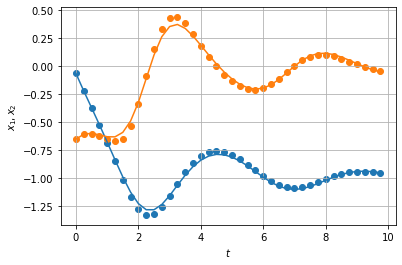

In [11]:
# RBF辞書の確認用
rbf_data = []
psi = rbf(num_clusters_rbf, rbf_centers)
K = K_rbf

for test_sample in test_data:
    x = test_sample.T[0]
    xs = np.zeros((0,dim))
    xs = np.concatenate([xs,x[np.newaxis,:]],0).T
    for step in range(test_data.shape[2]-1):
        psi_x = psi(x)
        next_dic =  K @ psi_x
        # RBF辞書の場合には、（0から数えて）1 と 2 の要素がそれぞれ x_1 と x_2 に対応。
        x = np.array([next_dic[1,0], next_dic[2,0]])
        x_T = x[np.newaxis,:].T
        xs = np.concatenate([xs,x_T],1)
    rbf_data.append(xs)

rbf_data = np.array(rbf_data)

# データのプロット（サンプル番号を一つ指定）
sample_number = 2
plt.grid()
plt.plot(time_array, test_data[sample_number][0])
plt.plot(time_array, test_data[sample_number][1])
plt.scatter(time_array, rbf_data[sample_number][0])
plt.scatter(time_array, rbf_data[sample_number][1])
plt.xlabel(r'$t$')
plt.ylabel(r'$x_1, x_2$')

Text(0, 0.5, 'MSE')

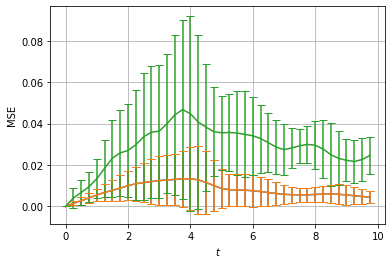

In [12]:
# 誤差のプロット

# べき乗辞書
mono_errors = []
for i, test_sample in enumerate(test_data):
    error = np.linalg.norm(test_data[i].T - mono_data[i].T, axis=1)
    mono_errors.append(error)
mono_errors = np.array(mono_errors)
mono_mean = np.mean(mono_errors, axis=0)
mono_std = np.std(mono_errors, axis=0)

# Hermite辞書
hermite_errors = []
for i, test_sample in enumerate(test_data):
    error = np.linalg.norm(test_data[i].T - hermite_data[i].T, axis=1)
    hermite_errors.append(error)
hermite_errors = np.array(hermite_errors)
hermite_mean = np.mean(hermite_errors, axis=0)
hermite_std = np.std(hermite_errors, axis=0)

# RBF辞書
rbf_errors = []
for i, test_sample in enumerate(test_data):
    error = np.linalg.norm(test_data[i].T - rbf_data[i].T, axis=1)
    rbf_errors.append(error)
rbf_errors = np.array(rbf_errors)
rbf_mean = np.mean(rbf_errors, axis=0)
rbf_std = np.std(rbf_errors, axis=0)

plt.grid()
plt.errorbar(time_array, mono_mean, yerr=mono_std, capsize=4)
plt.errorbar(time_array, hermite_mean, yerr=hermite_std, capsize=4)
plt.errorbar(time_array, rbf_mean, yerr=rbf_std, capsize=4)
plt.xlabel(r'$t$')
plt.ylabel(r'MSE')

#print(std)

In [13]:
# 辞書の数の確認
print("べき乗 & Hermite の辞書の大きさ: {0}".format(K_herm.shape[0]))
print("RBF の辞書の大きさ: {0}".format(K_rbf.shape[0]))

べき乗 & Hermite の辞書の大きさ: 10
RBF の辞書の大きさ: 23
